# Movies Recommendation Engine 

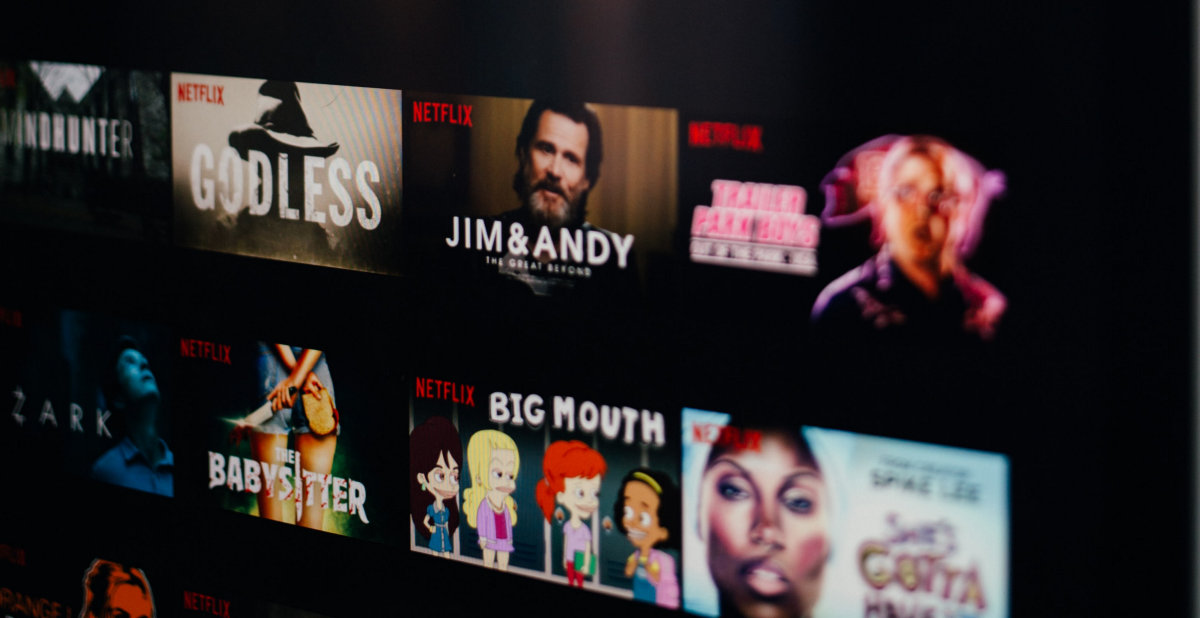

Recommender system is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.


There are some types of recommender systems:-

- Content Based Filtering : They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

- Collaborative Filtering : This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.



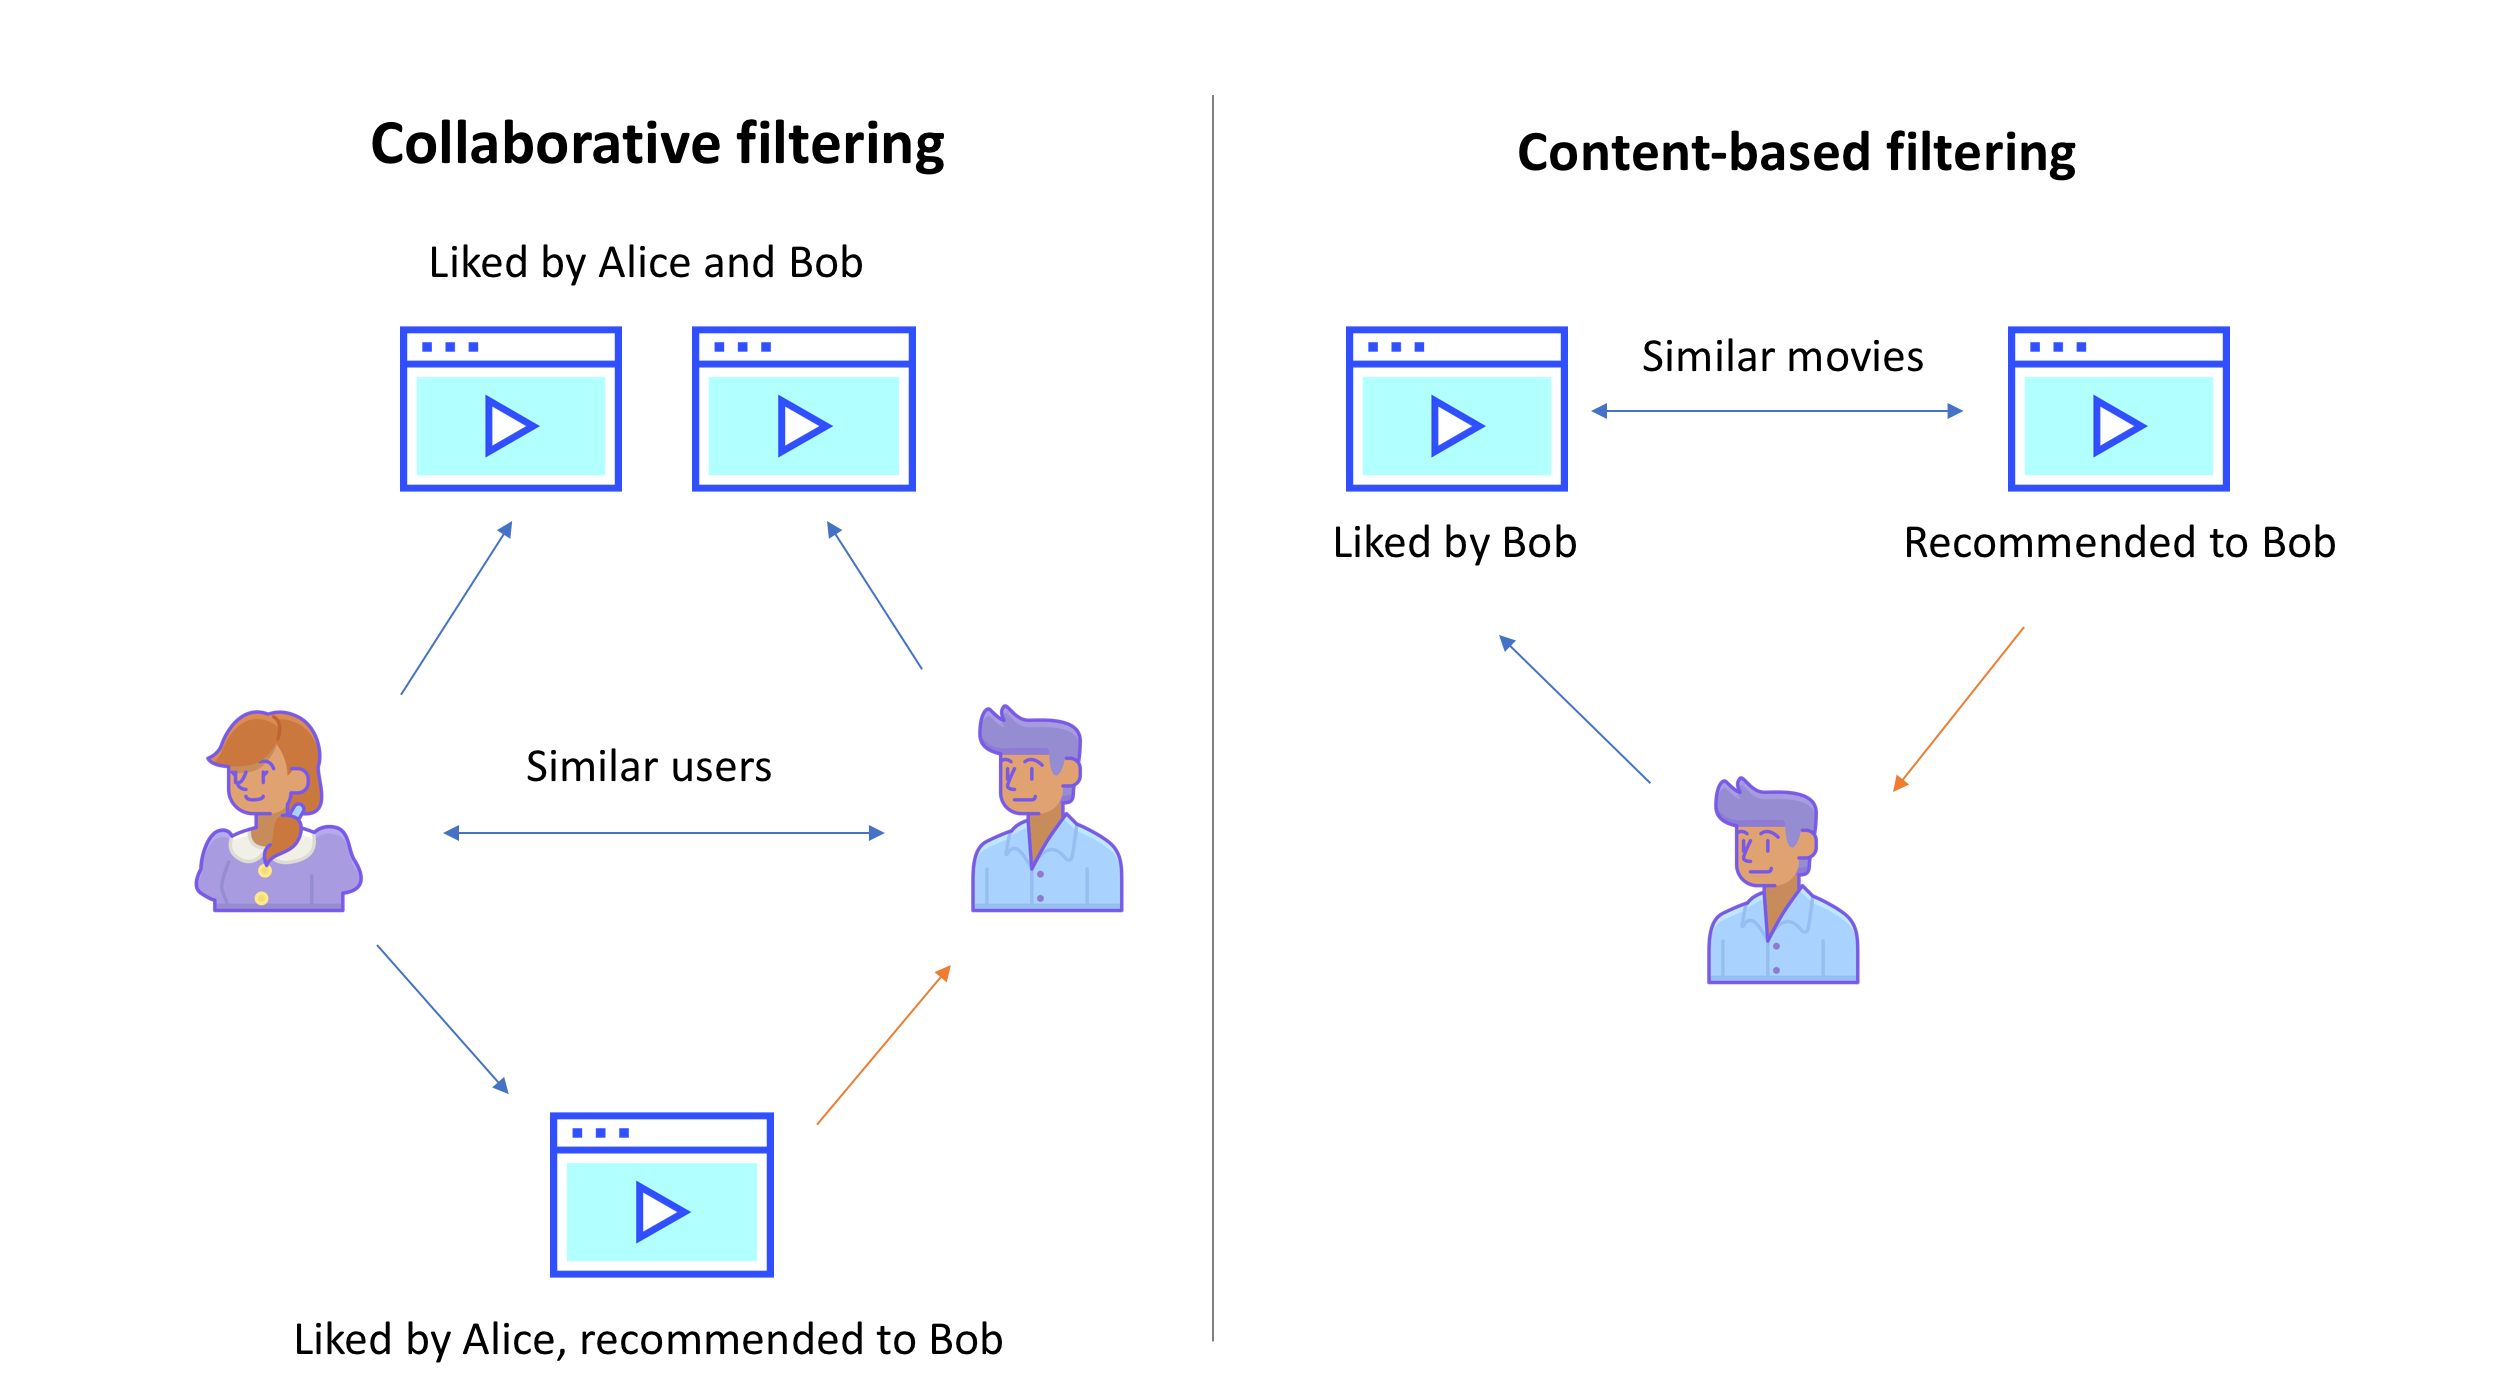

# Data Pre-Processing

We Will use `The Movies` Dataset From Kaggle


## 1.Importing Libraries

We Will import some essential libraries we will need in linear algebra process, data processing and cosine similarity algorithm

In [1]:
import numpy as np   # linear algebra
import pandas as pd  # data processing

from sklearn.metrics.pairwise import cosine_similarity  # To use Cosine Similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

## 2.Loading Data

In [2]:
ratings = pd.read_csv('ratings_small.csv')
movies = pd.read_csv('movies_metadata.csv',  usecols=['id', 'title', 'genres', 'overview'], nrows = 10000)

In [3]:
movies.columns.tolist()

['genres', 'id', 'overview', 'title']

## 3.inspecting Data

The ratings dataset contains the following features:-
- userID  : A unique identifier for each user.
- movieId : A unique identifier for each movie.
- rating : ratings the movie recieved by user.

The movies dataset contains the following features:-
- id  : A unique identifier for each movie.
- title : The title of the movies.
- geners : Movie geners
- overview : an overvie of the movie

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movies.head()

,genres,id,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Father of the Bride Part II


## 4.Checking Data

In [6]:
print(ratings.isna().sum())
print(movies.isna().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
genres       0
id           0
overview    29
title        0
dtype: int64


In [7]:
# Fill nan values with empty string
movies['overview'] = movies['overview'].fillna('')

**There are 6 movie have no title so we will drop**
- This step when we use the whole data

In [8]:
movies = movies[movies.title.notna()]

In [9]:
print(ratings.dtypes)
print(movies.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
genres      object
id           int64
overview    object
title       object
dtype: object


**In movies dataset the `id` type is object we will convert it to int**

In [10]:
movies['id'] = movies['id'].astype(int)

In [11]:
# Function to convert list to string
def listToString(s):  
    return (" ".join(s)) 

In [12]:
# Convert genres to list
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Convert this list to string
movies['genres'] = movies['genres'].apply(listToString)
movies.head()

,genres,id,overview,title
0,Animation Comedy Family,862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,Adventure Fantasy Family,8844,When siblings Judy and Peter discover an encha...,Jumanji
2,Romance Comedy,15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,Comedy Drama Romance,31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Comedy,11862,Just when George Banks has recovered from his ...,Father of the Bride Part II


# Content Based Recommender Based on `overview` and `genres`

In [13]:
# Inspect overview
movies['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [14]:
# Inspect genres
movies['genres'].head()

0     Animation Comedy Family
1    Adventure Fantasy Family
2              Romance Comedy
3        Comedy Drama Romance
4                      Comedy
Name: genres, dtype: object

In [15]:
# Combine the overview and genres
description = movies['genres'] + movies['overview']
description.head()

0    Animation Comedy FamilyLed by Woody, Andy's to...
1    Adventure Fantasy FamilyWhen siblings Judy and...
2    Romance ComedyA family wedding reignites the a...
3    Comedy Drama RomanceCheated on, mistreated and...
4    ComedyJust when George Banks has recovered fro...
dtype: object

In [16]:
# Transforms text to feature vectors
tf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tf.fit_transform(description)
tfidf_matrix.shape

(10000, 36160)

In [17]:
# Get the similarity using cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(10000, 10000)

In [18]:
# Get indices of the movies
indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()
indices[:10]

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
Sabrina                        6
Tom and Huck                   7
Sudden Death                   8
GoldenEye                      9
dtype: int64

In [19]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [20]:
# Using movie name to get recommendations
get_recommendations('Batman Forever')

3095          Batman: Mask of the Phantasm
1328                        Batman Returns
9230    Batman Beyond: Return of the Joker
1491                        Batman & Robin
7912                          The Clearing
585                                 Batman
2480                        Open Your Eyes
817                    Eyes Without a Face
9139          Batman & Mr. Freeze: SubZero
8170                      The Trojan Women
Name: title, dtype: object

# Collaborative Filtering

### Create User Rating Matrix

In [21]:
ratings_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get Similar Users

In [22]:
def getSimilarUsers(user):
    
    # Get the similarity using cosine similarity
    similarities = cosine_similarity(user, ratings_matrix)[0].tolist()
    
    # Get the indecies of these users
    similarities_index = ratings_matrix.index.tolist()
    
    # Combine the indecies with similarities
    similarities_dict = sorted(dict(zip(similarities_index, similarities)).items(), key=lambda x: x[1], reverse=True)
    
    # Get sorted indecies of similar users 
    similar_users = [u[0] for u in similarities_dict]
    
    # return 5 similar users
    # ignore the first one as it is the user(as we test on users in the data)
    return similar_users[1:6]

## Get Recommended Movies

In [23]:
def getRecommendedMovies(user):
    
    # Get the similar users
    similar_users = getSimilarUsers(user)
    
    # Rating matrix subset of similar users
    users = ratings_matrix[ratings_matrix.index.isin(similar_users)]
    users = users.transpose()
    
    # Get The mean rating of each movie and sort them
    users['mean'] = users.mean(axis=1)
    users_sorted = users.sort_values(by='mean', ascending=False)
    
    # prepare the user ratings
    user = user.transpose()
    user.columns = ['rating']
    
    # drop the movies that the user rated it
    user = user[user['rating'] == 0]
    
    # Get unseen movies indecies
    unseen_movies = user.index.tolist()
    
    # Get the recommended unseen movies with sorted mean
    recommended_movies = users_sorted[users_sorted.index.isin(unseen_movies)].sort_values(by='mean', ascending=False)
    
    # indecies of hieghest 5 recommended Movies
    moviesListIndex = recommended_movies[:5].index.tolist()
    
    # Get The Titles of These Movies
    moviesTitles = movies[movies['id'].isin(moviesListIndex)]
    
    return moviesTitles.title

In [24]:
# Get Recommendations Using user in our data
user = ratings_matrix[ratings_matrix.index == 555]
getRecommendedMovies(user)

1164    To Kill a Mockingbird
1328           Batman Returns
5624             Lili Marleen
Name: title, dtype: object